# CAB420, Sequences, Bonus Example: Bag of Words and Latent Dirichlet Allocation
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* ~~There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.~~ Actually, there is a TL;DR section here as I've moved this from the main content into the bonus content.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.


## Overview

In a previous bonus example, and in a week 6 summary example, we used bag-of-words to transform a variable length sequence into a fixed length representation. 

Bag of Words creates a histogram for each sequence, where each bin of the histogram corresponds to a word. As such, we go from a variable length document to a fixed length histogram where the length is controlled by the size of dictionary. While this sounds like a method that can only be used for language, we can create analogues for words in other domains, and as such this method is used quite broadly. One limitation of this however if that by building a histogram, we totally destroy any information on the order of the data.

Once we have this representation, there are other things we can do with it. We can:
* learn directly from it, treating it as the feature for our classifier
* pass it through another process, extracting a more compact representation

One popular family of methods used with Bag of Words is topic models. These model a document as a distribution of topics. A topic is a distribution of words. The topics themselves are learnt from the data, This means that we can then represent a sample not by the words that are in it, but by the topics that the doument contains. The method that we'll use for this is Latent Dirichlet Allocation (the other LDA), and this is, in essence, a clustering technique which aims to learn the topics from a large corpus of data. Like some of our other clustering techniques, it requires us to specify the number of topics (or clusters) up front.

## Too Long; Didn't Read:

* Bag of words creates a fixed length representation for a sequence, using a histogram of word occurances in a sequence. This guarantees that all sequences, even if they are different lengths, will have the same size representation. But it destroys all information about the order of the data.
* This representation can be used by a classify, or by another process to extract further information.
* Topic models are a method commonly used with bag of words representations, and can be seen as a type of clustering approach
* While a topic model will learn a far more compact representation, this does not guarantee improved performance as information may be lost.
* Topic models however can be used to improve the interperetability of the data. Manual inspection of the topics can allow them to be labelled, and then retrieval can be based on labels of combinations of labels

### Where does this fit into all the other CAB420 content?

This fits next to the earlier Bag-of-Words examples, and shows something else that we can do with that representation. We can also think of this as fitting somewhat next to our clustering methods, as we're learning distributions over the words (each topic is a distribution of words).

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

## The Data
We're still using twitter data, same as we've used in other sequence examples. Again we'll take a limited amount to help processing speed.

In [2]:
tweets = pandas.read_csv('../data/sentiment140/training.1600000.processed.noemoticon.csv', header = None)
print(tweets.head())

   0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


In the name of not running this for a week, we're just going to pull out a sample of the data.

In [3]:
tweet_text = tweets.iloc[:, -1].tolist()
Y = numpy.array(tweets.iloc[:, 0])

num_samples = 10000
train_samples = 8000
samples = numpy.random.choice(len(Y), num_samples)

train_X = [tweet_text[i] for i in samples[0:train_samples]]
train_Y = Y[samples[0:train_samples]]
test_X = [tweet_text[i] for i in samples[train_samples:]]
test_Y = Y[samples[train_samples:]]
print(numpy.shape(train_X))
print(numpy.shape(train_Y))
print(numpy.shape(test_X))
print(numpy.shape(test_Y))

(8000,)
(8000,)
(2000,)
(2000,)


## Bag of Words

We have a set of tokenised documents, so we can now get our Bag of Words. Note that I've got a couple of extra setting here:
* Any words that occur in fewer than 0.01% of documents will be excluded, i.e. I'll get rid of very rare words
* Any words that occur in over 25% of documents, I'll also get rid of, as really common words are also likely to be of little use

Both these thresholds are a little arbitrary, and you are welcome to play with them and see what happens.

In [4]:
count_vect = CountVectorizer(min_df=0.0001, max_df=0.25)
X_train_counts = count_vect.fit_transform(train_X)

We can have a look at some of the output. We can see that we now have a sparse matrix for the counts, and we can look at how we go from a tweet to a histogram (or bag or words) to represent that.

In [5]:
print(X_train_counts.shape)
print(train_X[2])
print(X_train_counts[2])

(8000, 15825)
wishes she has time for things. Missing Capoeira trainings especially Ginga.  http://plurk.com/p/xc7j5
  (0, 14009)	1
  (0, 5314)	1
  (0, 15250)	1
  (0, 12378)	1
  (0, 6180)	1
  (0, 13903)	1
  (0, 9208)	1
  (0, 2548)	1
  (0, 14243)	1
  (0, 4758)	1
  (0, 5699)	1
  (0, 6605)	1
  (0, 10783)	1
  (0, 3125)	1
  (0, 15435)	1


We can also have a look at the entire vocabulary. Note that everything is lowercase, and the punctuation is stripped out. The CountVectorizer does a certain amount of this pre-processing for us. What you can do is quite flexible, and if you're interested you're encouraged to check it out.

In [6]:
print(count_vect.vocabulary_)

{'time': 14009, 'for': 5314, 'sleep': 12676, 'work': 15331, 'at': 1347, '9am': 503, 'and': 1026, 'it': 7062, 'is': 7037, 'double': 4260, 'on': 10106, 'my': 9544, 'way': 15013, 'dc': 3777, 'with': 15258, 'sister': 12613, 'hell': 6316, 'yeahhhh': 15560, 'wishes': 15250, 'she': 12378, 'has': 6180, 'things': 13903, 'missing': 9208, 'capoeira': 2548, 'trainings': 14243, 'especially': 4758, 'ginga': 5699, 'http': 6605, 'plurk': 10783, 'com': 3125, 'xc7j5': 15435, 'moviee': 9420, 'awardsssss': 1447, 'amandahnk': 960, 'hey': 6360, 'there': 13863, 'amanda': 957, 'huuuuuuuhhh': 6665, 'so': 12788, 'left': 8128, 'wallet': 14946, 'in': 6835, 'desk': 3965, 'called': 2471, 'myself': 9561, 'tryin': 14336, 'go': 5777, 'out': 10235, '2nite': 177, 'but': 2398, 'license': 8199, 'thephace': 13856, 'that': 13789, 'full': 5482, 'plate': 10745, 'good': 5810, 'see': 12206, 'you': 15630, 'optimistic': 10168, 'change': 2733, 'breakfast': 2191, 'sausage': 12052, 'biscut': 1899, 'hashbrown': 6183, 'apple': 1170, '

Finally, we'll transform our test data into the same representation

In [7]:
X_test_counts = count_vect.transform(test_X)
print(X_test_counts.shape)

(2000, 15825)


One thing to note here is the size of this output. Each of our features is over $15,000$ elements in length. If we thought our $3,800$ length representations were big last time, they're nothing compared to what we have now.

## Approach 1: Learning on BoW Features
Obviously, we can just learn directly on the BoW features. However much like we had with the previous example, this leads to very high dimensional features which may be slow.

Here, we're going to use an SVM. In this case we'll use a linear SVM, as we have a very high dimensional feature representation, which also contains a lot of 0's (i.e. it's a sparse representation).

              precision    recall  f1-score   support

           0       0.73      0.74      0.73      1018
           4       0.73      0.71      0.72       982

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



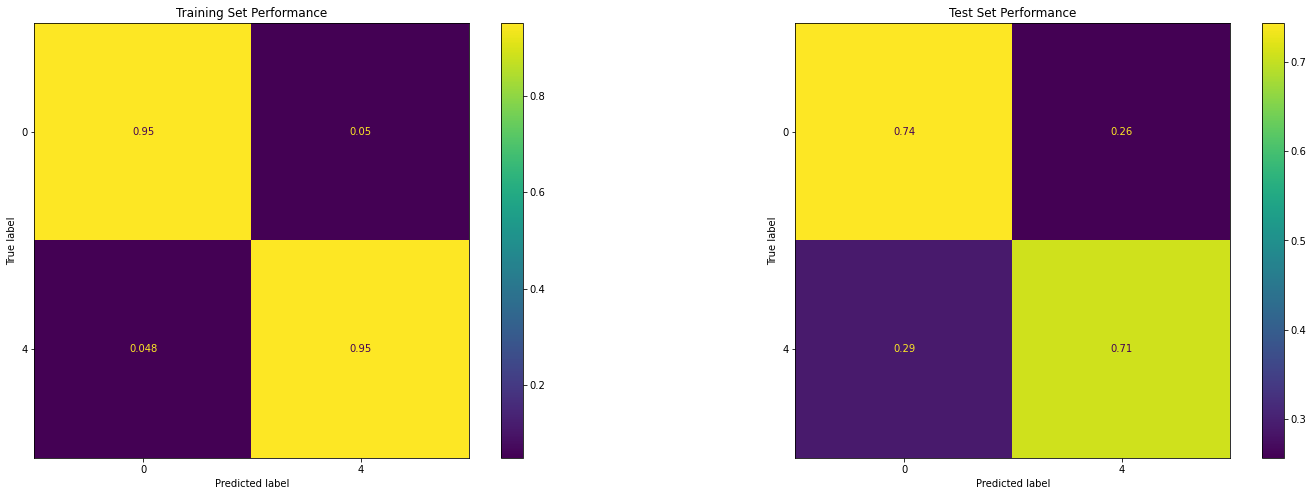

In [8]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance');
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Test Set Performance');
    pred = model.predict(X_test)
    print(classification_report(Y_test, model.predict(X_test))) 
    
svm = SVC()
svm.fit(X_train_counts, train_Y)
eval_model(svm, X_train_counts, train_Y, X_test_counts, test_Y)

This actually works pretty well - much better than what we had before. If we consider the same three silly tweets discussed at the end of the last example we'd get the following histograms:
* This is a positive tweet -> {is: 1, negative: 0, positive: 1, this: 1, tweet 1} 
* Positive tweet, this is  -> {is: 1, negative: 0, positive: 1, this: 1, tweet 1} 
* This is a negative tweet -> {is: 1, negative: 1, positive: 0, this: 1, tweet 1} 

Our two positive tweets get the exact same feature encoding, so it's really easy to group them together. Comparing our negative and positive tweets, we have the histogram counts of the words "positive" and "negative" that we can use to easily separate the two classes of tweets. Essentially, our model can use this representation and learn a hyperplane that has all the "positive" words and "negative" words on opposite sides of the hyperplane.

## Latent Dirichlet Allocation

We'll fit an LDA model now and have a look at the results. We'll pick 12 topics, for no other reason than it's an 
easy number to work with.

In [9]:
lda = LatentDirichletAllocation(n_components=12, random_state=0)
lda.fit(X_train_counts)

LatentDirichletAllocation(n_components=12, random_state=0)

In [10]:
X_train_topics = lda.transform(X_train_counts)
X_test_topics = lda.transform(X_test_counts)

We'll just look at part of the topic probabilities as it's a bit big to look at all of it, but we can see from the first four topics here that they are all capturing different sets of words - even if there is some overlap.

(12, 15825)


<BarContainer object of 1000 artists>

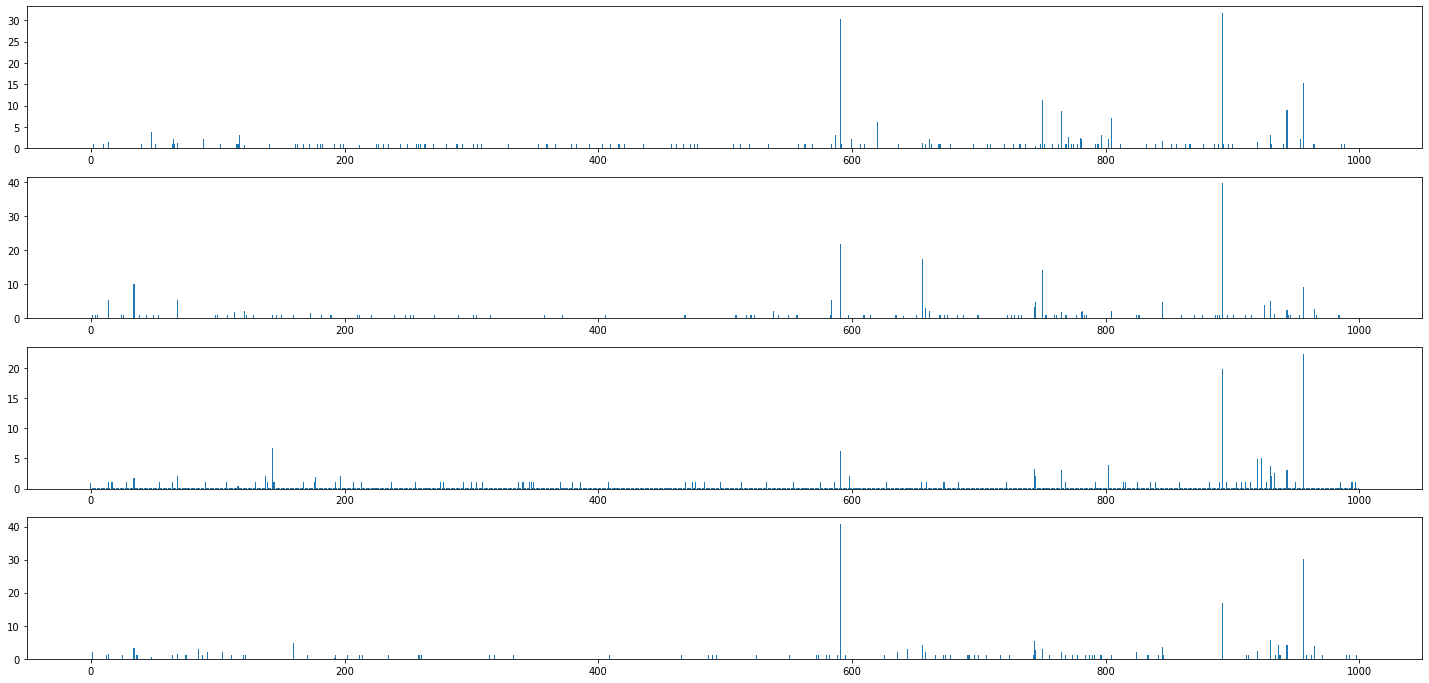

In [11]:
print(numpy.shape(lda.components_))
fig = plt.figure(figsize=[25, 12])
ax = fig.add_subplot(4, 1, 1)
ax.bar(range(1000), lda.components_[0, 0:1000])
ax = fig.add_subplot(4, 1, 2)
ax.bar(range(1000), lda.components_[1, 0:1000])
ax = fig.add_subplot(4, 1, 3)
ax.bar(range(1000), lda.components_[2, 0:1000])
ax = fig.add_subplot(4, 1, 4)
ax.bar(range(1000), lda.components_[3, 0:1000])

This makes sense. We'd expect some common words to appear across most, if not all topics, while other words will only appear in a single topic.

Looking at the documents (tweets) now, we can see that different tweets belong to different topics, with documents belonging to multiple topics, and some belonging to more than others. From this sort of representation we can also decide how similar to things are. If two tweets for example have very similar topic distributions, then they are likely about the same thing (of course, this relies on the topics themselves being sensible).

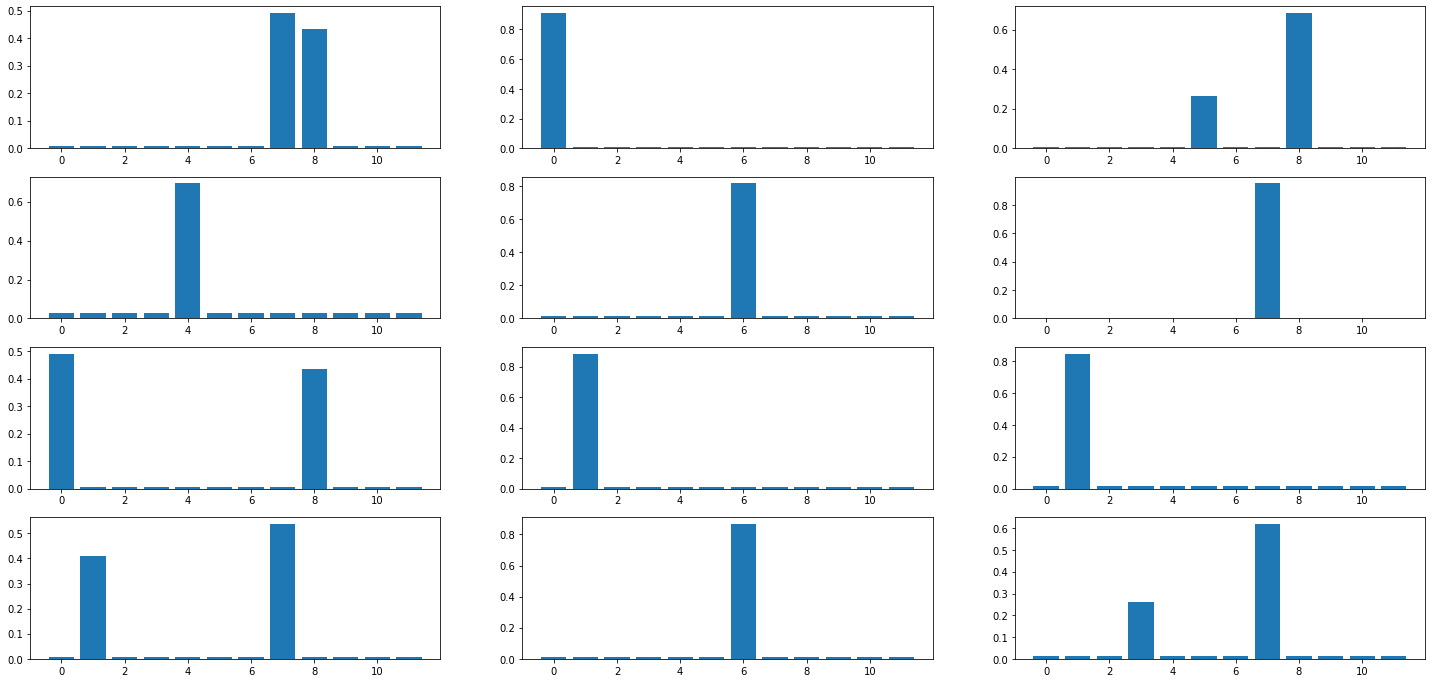

In [12]:
fig = plt.figure(figsize=[25, 12])
for i in range(12):
    ax = fig.add_subplot(4, 3, i+1)
    ax.bar(range(12), X_train_topics[i, :])

## How Many Topics?
As we've seen with clustering (KMeans and GMMs), one challenge we have is setting the number of topics. 
In the case of LDA, we can use the perplexity to help decide that, looking for a minimum on the curve of perplexity vs number of topics.

In [13]:
perplexity = []
topics = []
for i in range(10, 210, 10):
    lda = LatentDirichletAllocation(n_components=i, random_state=0)
    lda.fit(X_train_counts)
    perplexity.append(lda.bound_)
    topics.append(i)

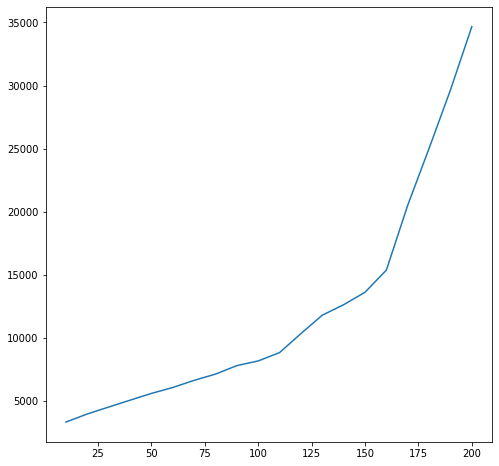

In [14]:
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(topics, perplexity)

It turns out there's a bug in sklearns perplexity code (see [here](https://stackoverflow.com/questions/45658014/how-to-interpret-sklearn-lda-perplexity-score-why-it-always-increase-as-number/46517326#46517326)) and it goes up when it should go down, so we'll look for a large value rather than a small one.

We'll go with 200 topics as that seems like more than enough for our needs.

## Approach 2: LDA, then an SVM
Now, we'll use LDA to get a more compact representation, and then we'll fit an SVM to it. Essentially, we'll try to separate the tweets based on the topic distribution rather than the raw words.

Note that here, we're using an RBF SVM. Why the change? Earlier we had a very high dimensional feature which was very sparse (contained a lot of 0's), which is somewhere that linear SVMs typically perform well. Now we have a much smaller representation, which we expect to be a lot less sparse. Hence the change.

              precision    recall  f1-score   support

           0       0.59      0.67      0.62      1018
           4       0.60      0.52      0.55       982

    accuracy                           0.59      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.59      0.59      0.59      2000



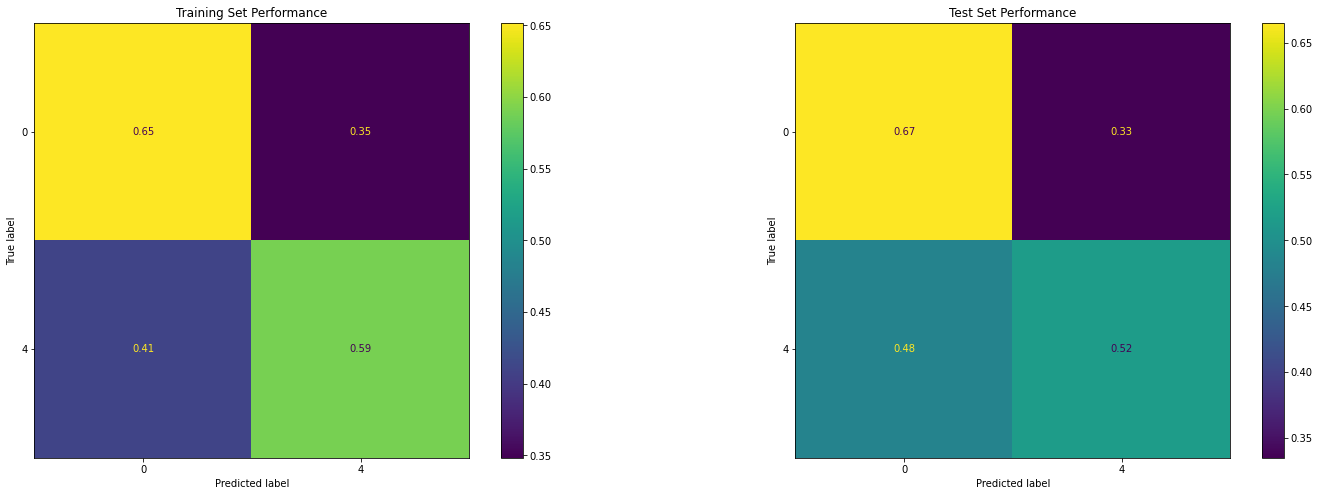

In [16]:
lda = LatentDirichletAllocation(n_components=200, random_state=0)
lda.fit(X_train_counts)
X_train_topics = lda.transform(X_train_counts)
X_test_topics = lda.transform(X_test_counts)

svm = SVC(kernel='rbf', C = 1)
svm.fit(X_train_topics, train_Y)
eval_model(svm, X_train_topics, train_Y, X_test_topics, test_Y)

Our model is not great, and does not perform as well as what we had before, but we could optimise this and do much better.

That said, we should consider what's happening here. We're now using the output of one model as the input to another. So if the topics we've learnt are not correct, or not imformative, them we're going to end up with sub-optimal results. We also have very short documents (they're tweets), so trying to infer topics from such short pieces of text is perhaps a challenge. Finally, if we consider our three example tweets:
* This is a positve tweet
* Positive tweet, this is
* Negative tweet, this is

The topic of these tweets is essentially "tweets", i.e. they're all the same. "Positive" or "Negative" are not really topics as such, though with the right number of topics in the topic model you may still be able to pull these out.

## Final Thoughts

Bag of words (BoW) allows us to get a fixed length representation for a variable length sequence, but it destroys all information on order (which may or may not be important, depending on your task).

BoW will also not necessarily make your features smaller, as if you have a large vocabulary, your representation will still be huge. However using a topic we can represent the words as a distribution of topics, which will be more compact. This will throw away some information (i.e. we no longer know what the words are for example), but it will also make our features much smaller. Topic models are also something that can be visualised and interpereted. Semantic meanings can be attached to topics, and so there are some interesting possibilities for retrieval and knowledge discovery based on the topics. The topic distributions also offer a way to find similar or related examples, based on examples having similar topic distributions.